In [1]:
%pylab
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Least Squares and Nearest Neighbors

(From Elements of Statistical Learning - Chapter 2.3)

Least squares and nearest neighbors are two basic techniques for data classification / supervised learning. Given a training set of vectors $\mathbf{X} \in \mathbb{R}{N \times (p+1)}$ where each column consists of a "input" data vector $x^T = (X_0\!=\!1, X_1, \ldots, X_p) \in \mathbb{R}^{p+1}$. Since this is a "training set" we can assume we know the observed output $\mathbf{Y} \in \mathbb{R}^N$ for each column vector.

In the examples below we begin with some data consisting of points in the plane $x_i^T = (1, X_{i1}, X_{i2})$ (i.e. $p=2$) with correspodning observations $y_i \in \{0,1\}$. In this case, $y_i = 0$ corresponds to "blue" and $y_i = 1$ corresponds to "orange"

For example:

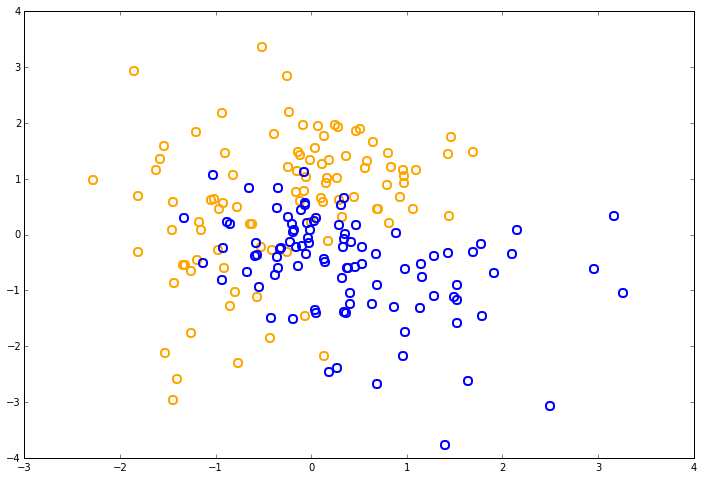

In [131]:
# generate some random 0/1 (Blue/Orange data) for the training set
n = 48
p = 2

# orange data
random.seed(0)
orange_X = ([0.5,1.5]*randn(n,p) + [-1,0])
orange_X = append([0.5,0.5]*randn(n,p) + [0.5,1], orange_X, axis=0)
n_orange = len(orange_X)

# blue data
blue_X = ([1,1]*randn(n,p) + [1,-1])
blue_X = append([0.5,0.5]*randn(n,p) + [0,0], blue_X, axis=0)
n_blue = len(blue_X)

# aggregate all the data and insert "bias variable" X_0 = 1
X = append(orange_X, blue_X, axis=0)
X = insert(X,0,1,axis=1)
N = n_orange + n_blue

# responses: blue = 0, orange = 1
orange_Y = ones(n_orange)
blue_Y = zeros(n_blue)
Y = append(orange_Y, blue_Y)

# plot the known data
plot_kwds = {'marker':'o', 'linestyle':'none', 'fillstyle':'none', 'markersize':8, 'markeredgewidth':2}
plot(orange_X[:,0], orange_X[:,1], color='orange', **plot_kwds)
plot(blue_X[:,0], blue_X[:,1], color='blue', **plot_kwds)

## Linear Models

Linear models are one fo the simplest ways to classify data. Basically, the idea is to find a hyperplane (in this case when $p=2$, a line) that best separates the data. (Again, in this case is data $y_i \in \{0, 1\}$.) We will find a parameter set $\beta^T = (\beta_0, \beta_1, \ldots, \beta_p)$ such that the function

$$\hat{Y}(X) = X^T\beta$$

best approximates the observed values in some way. That is

$$y_i \approx \hat{Y}(x_i).$$

To do so we can find $beta$ so as to minimize the error

$$\text{err}(\beta) = \sum_{i=1}^{N} \left( y_i - x_i^T \beta \right)^2.$$

over the training set. It's not difficult to prove that this is can be done by solving the "normal equations"

$$(\mathbf{X}^T\mathbf{X}) \beta = \mathbf{X}^T \mathbf{y}.$$

In [132]:
# solve least squares using normal equations (inefficient, but exact)
beta = solve(dot(X.T,X), dot(X.T,Y))
beta

array([ 0.5057228 , -0.14657079,  0.18023412])

## Linear Model Classification

Now that we have the optimal parameters, $\beta$, for the training set we can use them to classify additional / new data introduced into the system. Given a new data point $x$ we compute

$$\tilde{y}(x) = x^t \beta.$$

The range of $\tilde{y}(\beta)$ is $\mathbb{R}$, not the desired output range $G$. So we make the definiton:

$$y(x)
=
\begin{cases}
1, \text{ if } x^T \beta > 0.5 \\
0, \text{ if } x^T \beta \leq 0.5
\end{cases}
$$

To visualize how well the method performs in this classification problem we compute $y(x)$ for $x$ varying over a grid of input points.

In [133]:
# generate a uniform grid in the space occupied by the training data

M = 64  # sqrt of number of grid points
x1a, x1b = floor(min(X[:,1])), ceil(max(X[:,1]))
x2a, x2b = floor(min(X[:,2])), ceil(max(X[:,2]))
x1 = linspace(x1a,x1b,NGRID)
x2 = linspace(x2a,x2b,NGRID)
X1, X2 = meshgrid(x1, x2)

Xgrid = zeros((M,M,p+1))
Xgrid[:,:,0] = ones((M,M))
Xgrid[:,:,1] = X1
Xgrid[:,:,2] = X2

# compute the inner product x^T beta for each x in the grid
Ygrid = einsum('...k,k->...', Xgrid, beta)

# the orange-classified points are the ones with x^T beta > 0.5
grid_orange = Xgrid[Ygrid>0.5]
grid_blue = Xgrid[Ygrid<=0.5]

<matplotlib.contour.QuadContourSet instance at 0x10f00e320>

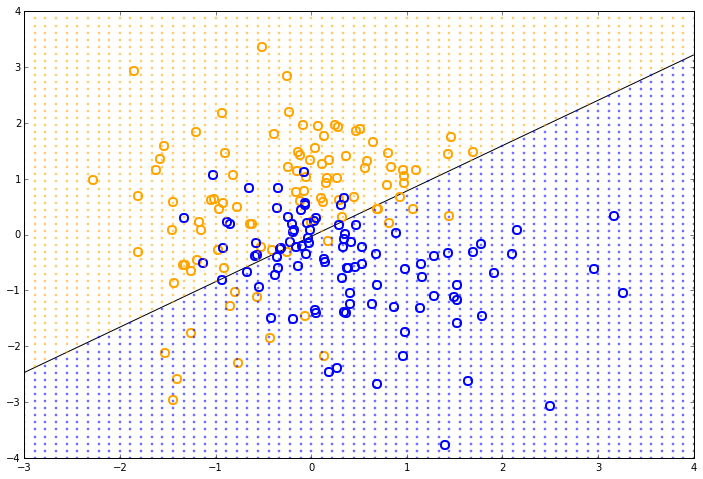

In [134]:
# plot the original training data
training_plot = {'marker':'o', 'linestyle':'none', 'fillstyle':'none', 'markersize':8, 'markeredgewidth':2}
plot(orange_X[:,0], orange_X[:,1], color='orange', **training_plot)
plot(blue_X[:,0], blue_X[:,1], color='blue', **training_plot)

# plot the classified grid points
grid_plot = training_plot.copy()
grid_plot['marker'] = '.'
grid_plot['markersize'] = 1
plot(grid_orange[:,1], grid_orange[:,2], color='orange', **grid_plot)
plot(grid_blue[:,1], grid_blue[:,2], color='blue', **grid_plot)

# plot the separating line / contour (where x^T beta = 0.5)
contour(Xgrid[:,:,1], Xgrid[:,:,2], Ygrid, levels=[0.5], color='k', linewidth=5, cmap=cm.gray)

## Nearest Neighbor Approach

In [135]:
# nearest beightbor approach: for each 
def k_nearest_neighbor_indices(point, training_data=None, k=1):
    training_data = array(training_data)
    point = array(point)
    
    vectors = training_data - point
    distances = norm(vectors, axis=1)
    sorted_indices = argsort(distances)
    return sorted_indices

def NN_value(point, training_data=None, k=1):
    idx = k_nearest_neighbor_indices(point, training_data=training_data, k=k)
    yNN = sum(Y[idx[:k]]) / k
    return yNN

In [136]:
Ygrid_NN = apply_along_axis(NN_value, 2, Xgrid, training_data=X, k=2)

grid_NN_orange = Xgrid[Ygrid_NN>0.5]
grid_NN_blue = Xgrid[Ygrid_NN<=0.5]

<matplotlib.contour.QuadContourSet instance at 0x10f236200>

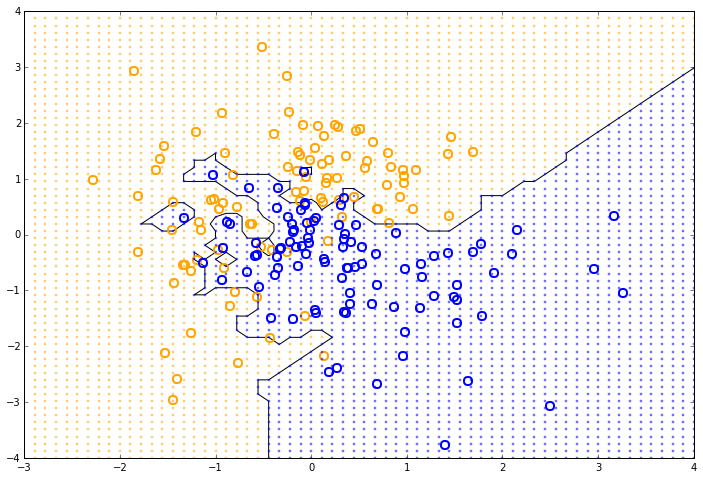

In [137]:
# plot the original training data
training_plot = {'marker':'o', 'linestyle':'none', 'fillstyle':'none', 'markersize':8, 'markeredgewidth':2}
plot(orange_X[:,0], orange_X[:,1], color='orange', **training_plot)
plot(blue_X[:,0], blue_X[:,1], color='blue', **training_plot)

# plot the classified grid points
grid_plot = training_plot.copy()
grid_plot['marker'] = '.'
grid_plot['markersize'] = 1
plot(grid_NN_orange[:,1], grid_NN_orange[:,2], color='orange', **grid_plot)
plot(grid_NN_blue[:,1], grid_NN_blue[:,2], color='blue', **grid_plot)

# plot the separating line / contour (where x^T beta = 0.5)
contour(Xgrid[:,:,1], Xgrid[:,:,2], Ygrid_NN, levels=[0.5], color='k', linewidth=5, cmap=cm.gray)

<matplotlib.contour.QuadContourSet instance at 0x10f449cf8>

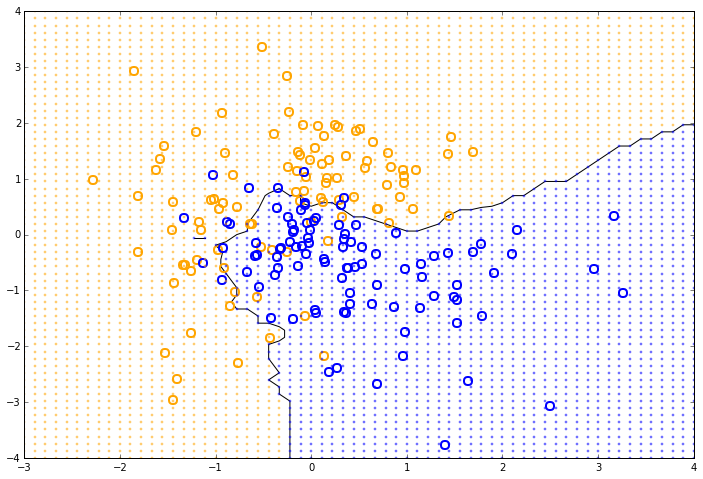

In [138]:
Ygrid_NN = apply_along_axis(NN_value, 2, Xgrid, training_data=X, k=10)
grid_NN_orange = Xgrid[Ygrid_NN>0.5]
grid_NN_blue = Xgrid[Ygrid_NN<=0.5]


# plot the original training data
training_plot = {'marker':'o', 'linestyle':'none', 'fillstyle':'none', 'markersize':8, 'markeredgewidth':2}
plot(orange_X[:,0], orange_X[:,1], color='orange', **training_plot)
plot(blue_X[:,0], blue_X[:,1], color='blue', **training_plot)

# plot the classified grid points
grid_plot = training_plot.copy()
grid_plot['marker'] = '.'
grid_plot['markersize'] = 1
plot(grid_NN_orange[:,1], grid_NN_orange[:,2], color='orange', **grid_plot)
plot(grid_NN_blue[:,1], grid_NN_blue[:,2], color='blue', **grid_plot)

# plot the separating line / contour (where x^T beta = 0.5)
contour(Xgrid[:,:,1], Xgrid[:,:,2], Ygrid_NN, levels=[0.5], color='k', linewidth=5, cmap=cm.gray)

<matplotlib.contour.QuadContourSet instance at 0x11092c128>

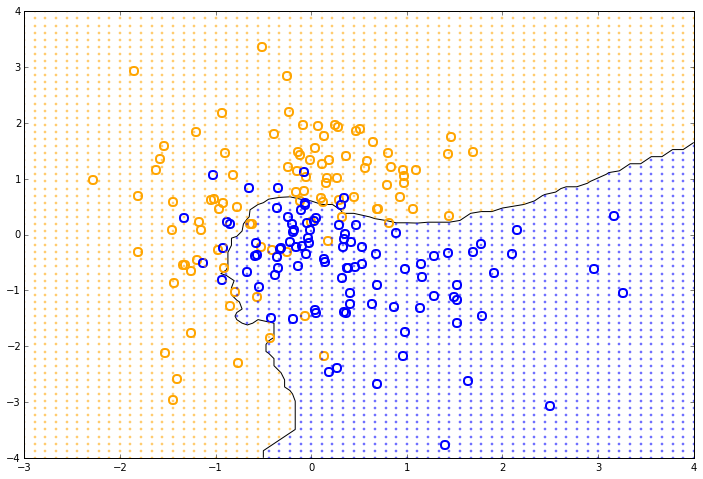

In [143]:
Ygrid_NN = apply_along_axis(NN_value, 2, Xgrid, training_data=X, k=15)
grid_NN_orange = Xgrid[Ygrid_NN>0.5]
grid_NN_blue = Xgrid[Ygrid_NN<=0.5]


# plot the original training data
training_plot = {'marker':'o', 'linestyle':'none', 'fillstyle':'none', 'markersize':8, 'markeredgewidth':2}
plot(orange_X[:,0], orange_X[:,1], color='orange', **training_plot)
plot(blue_X[:,0], blue_X[:,1], color='blue', **training_plot)

# plot the classified grid points
grid_plot = training_plot.copy()
grid_plot['marker'] = '.'
grid_plot['markersize'] = 1
plot(grid_NN_orange[:,1], grid_NN_orange[:,2], color='orange', **grid_plot)
plot(grid_NN_blue[:,1], grid_NN_blue[:,2], color='blue', **grid_plot)

# plot the separating line / contour (where x^T beta = 0.5)
contour(Xgrid[:,:,1], Xgrid[:,:,2], Ygrid_NN, levels=[0.5], color='k', linewidth=5, cmap=cm.gray)